# DATA 612 Project 3 - Matrix Factorization

By Mike Silva

## Introduction

This is an implementation of a matrix factorization method in the context of a recommender system.  For this project I will be using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/).

### About the MovieLens Dataset

The MovieLens datasets were collected by GroupLens Research at the University of Minnesota.  This particular data set has 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.  It is the data set the GroupLens group recommends for research and education.  It is not a static data set.  The data I will be using was last updated in September of 2018.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import requests
import zipfile
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("ml-latest-small.zip"):
    # We need to download it
    response = requests.get("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
    if response.status_code == 200:
        with open("ml-latest-small.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT THE DATA SET
if not os.path.exists("ratings.csv"):
    with zipfile.ZipFile("ml-latest-small.zip","r") as z:
        z.extractall()
# STEP 3 - READ ING THE DATA
ratings = pd.read_csv("ml-latest-small/ratings.csv") 
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Since we have a time stamp we are going to use it to split the data into training, validation and test sets.  We will use and 80/10/10 split.  I will train the model on 80% of the data, use 10% to develop the best model I can by tuning parameters, and then apply it to 10% of the data to see how it would actually preform.

In [2]:
def train_test_split(df, test_proportion = .2):
    test_length = int(len(df) * test_proportion)
    train_length = len(df) - test_length
    test_df = df.tail(test_length)
    train_df = df.head(train_length)
    return (train_df, test_df)
    
ratings_train, temp = train_test_split(ratings)
ratings_evaluation, ratings_test = train_test_split(temp, 0.5)

Now that the data is split I will create a user item matrix filling in all the missing values with zeros.

In [3]:
A = ratings_train.pivot(index="userId", columns="movieId", values="rating").fillna(0)
A

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building the SVD Model

Now that we have the training dataset prepared we can start making SVD predictions.  This function allows the user to adjust the number of singular values to keep so they can control how the dimensionality reduction factor.  It also give the option to adjust for the user's rating bias.

In [4]:
def get_svd_predictions(A, k, adjust_for_user_bias = False):
    """Get ratings predictions using SVD.
        Args:
    A (DataFrame): The user item rating matrix
    k (int): The number of singular values
    adjust_for_user_bias (bool): Should A be adjusted by the user mean? (Optional: False default)
        Returns:
    predictions (DataFrame): Predicted user item rating matrix
    """
    # Check if we need to remove the user bias
    if adjust_for_user_bias:
        user_ratings_mean = np.mean(A.values, axis=1)
        A = A - user_ratings_mean.reshape(-1, 1)
    # Do the SVD decomposition
    U, sigma, Vt = svds(A, k=k)
    sigma = np.diag(sigma)
    # Build the prediction matrix
    predictions = np.dot(np.dot(U, sigma), Vt)
    # Check if we need to add back in the user bias
    if adjust_for_user_bias:
        predictions = predictions + user_ratings_mean.reshape(-1, 1)
    # Let's round it to the nearest half
    predictions = np.matrix.round(predictions * 2, 0) / 2
    # Make sure values are between 0 and 5
    predictions[predictions < 0] = 0
    predictions[predictions > 5] = 5
    # Return the predictions
    predictions = pd.DataFrame(predictions, index=A.index, columns=A.columns)
    return predictions

svd_predictions = get_svd_predictions(A, 100)
svd_predictions

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,-0.0,4.0,0.0,0.0,4.5,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
4,-0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,-0.0,1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
506,0.5,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.5,0.5,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


Now that I can produce predictions I need to evaluate them against the validation set and tune the k parameter to minimize the error.  I will be using the average ratings to fill in blanks when I need it.

In [5]:
average_rating = round(ratings_test['rating'].mean() * 2, 0) / 2

def get_svd_RMSE(predictions, ratings_evaluation, average_rating):
    """Get the RMSE for a set of test data based off of predictions.
    Args:
        predictions (DataFrame): user to items rating prediction matrix
        ratings_evaluation (DataFrame): Evaluation set of ratings
        average_rating (float): Rating to substitute in when no ratings are available
    Returns:
        RMSE (float): The RMSE for the test set
    """
    predictions_long = pd.melt(predictions.reset_index(), id_vars=['userId'], var_name='movieId', value_name='yhat_rating')
    eval_df = pd.merge(ratings_evaluation, predictions_long, how="left").fillna(average_rating)
    eval_df['error'] = eval_df['yhat_rating'] - eval_df['rating']
    eval_df['squared_error'] = eval_df['error'] ** 2
    mean_squared_error = eval_df['squared_error'].mean()
    RMSE = mean_squared_error ** (1/2)
    return RMSE

get_svd_RMSE(svd_predictions, ratings_evaluation, average_rating)

1.1435103958367634

The RMSE for the SVD model that is not adjusted for user bias and using a k of 100 is 1.14.  Now I will try to tune the k parameter by finding the k that minimizes the RMSE.  I will first preform a grid search using a wide interval and then narrow it once I have looked at the data.

In [6]:
svd_RMSEs = []
for k in range(1, 500, 50):
    svd_predictions = get_svd_predictions(A, k)
    RMSE = get_svd_RMSE(svd_predictions, ratings_evaluation, average_rating)
    svd_RMSEs.append({'k':k, 'RMSE':RMSE})

svd_RMSEs = pd.DataFrame(svd_RMSEs)

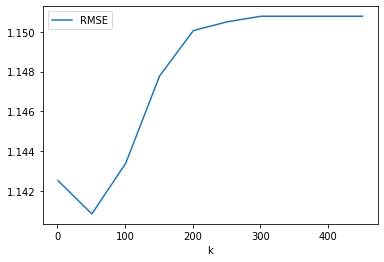

In [7]:
svd_RMSEs.plot(x='k', y='RMSE')

It looks like the optimal value for k is between 10 and 100.  Let's search for this optimal k.

In [8]:
min_RMSE = 100
optimal_k = 0
RMSEs = []

for k in range(10, 100, 1):
    svd_predictions = get_svd_predictions(A, k)
    RMSE = get_svd_RMSE(svd_predictions, ratings_evaluation, average_rating)
    RMSEs.append({'k':k, 'RMSE':RMSE})
    if RMSE < min_RMSE:
        min_RMSE = RMSE
        optimal_k = k

print("A k of " + str(optimal_k) + " gives an RMSE of " + str(min_RMSE) + " on the evaluation set")

A k of 13 gives an RMSE of 1.137815955570362 on the evaluation set


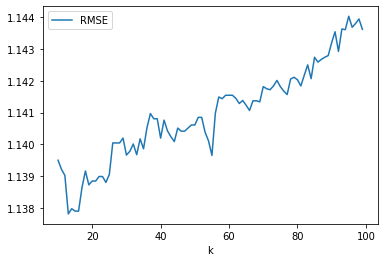

In [9]:
RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

Now that we have an optimal k value on our evaluation set, let's see how the model preforms on the test set.

In [10]:
svd_predictions = get_svd_predictions(A, optimal_k)
get_svd_RMSE(svd_predictions, ratings_test, average_rating)

1.0492319250999815

This SVD model has a RMSE of about 1.05.

### User Biased Adjusted SVD Model

I will repeat the process except for this time I will adjust for the user bias.  I will do a grid search using a wide range, assume the errors are somewhat linear in nature, and take a deep dive to see where the optimal k lies.

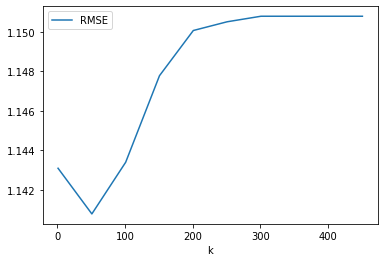

In [11]:
RMSEs = []
for k in range(1, 500, 50):
    svd_predictions = get_svd_predictions(A, k, True)
    RMSE = get_svd_RMSE(svd_predictions, ratings_evaluation, average_rating)
    RMSEs.append({'k':k, 'RMSE':RMSE})

RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

This appears to be preforming slightly better than the SVD on data that hasn't been adjusted for the user bias.  I think we are going to stick with this approach for the model.  Let's determine the optimal k value for this dataset.

In [12]:
min_RMSE = 100
optimal_k = 0

RMSEs = []

for k in range(10, 100, 1):
    svd_predictions = get_svd_predictions(A, k, True)
    RMSE = get_svd_RMSE(svd_predictions, ratings_evaluation, average_rating)
    RMSEs.append({'k':k, 'RMSE':RMSE})
    if RMSE < min_RMSE:
        min_RMSE = RMSE
        optimal_k = k

print("A k of " + str(optimal_k) + " gives an RMSE of " + str(min_RMSE) + " on the evaluation set")

A k of 15 gives an RMSE of 1.137903107801777 on the evaluation set


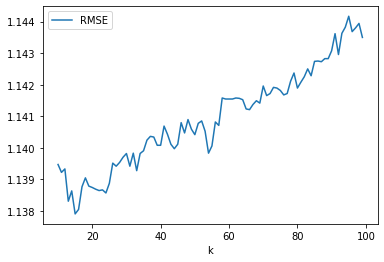

In [13]:
RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

In [14]:
svd_predictions = get_svd_predictions(A, optimal_k, True)
get_svd_RMSE(svd_predictions, ratings_test, average_rating)

1.0492319250999815

This gives a similar outcome in terms of RMSE as the unadjusted SVD model.

## How Does This Compare to Collaborative Filtering?

How do these two SVD models preform in comparison to a collaborative filtering approach.  I cannot produce a user to user collaborative filter due to the amount of memory required to compute the cosine similarities.  I am able to produce an item to item collaborative filter, which is preferable anyways.

In order to do that I need to transpose the existing matrix and remove the mean ratings prior to computing the cosine similarities.

In [15]:
At = A.transpose()
item_ratings_mean = np.mean(At.values, axis=1)
adjusted_At = At - item_ratings_mean.reshape(-1, 1)
cosine_similarity_matrix = cosine_similarity(adjusted_At)
cosine_similarity_matrix = pd.DataFrame(cosine_similarity_matrix, index=At.index, columns=At.index)

Now that I have a cosine similarity matrix I will find the group of movies that are its neighbors and average the ratings users gave of the movies.  This is what I will use as a prediction.  I will further adjust it so that it is on the nearest half star rating.

In [16]:
def get_item_item_cf_prediction(ratings_train, cosine_similarity_matrix, k, movie_id):
    """Get ratings predictions using an item based collaborative filter.
    Args:
        ratings_train (DataFrame): The training set of ratings 
        cosine_similarity_matrix (DataFrame): The cosine similarity matrix in data frame form
        k (int): the number of neighbors you want included in the neighborhood.
        movie_id (int): The id of the movie you want rating predictions for
    Returns:
        prediction (float): A number between 0 and 5 rounded to the nearest half
    """
    # Transform the row into a long data frame and reset the index to add the movieId
    temp = pd.DataFrame(cosine_similarity_matrix.loc[movie_id]).reset_index()
    # Sort the data frame in decreasing order of cosine similarity
    temp = temp.sort_values(movie_id, ascending = False)
    # Drop the row with it's own similarity
    temp = temp[temp['movieId'] != movie_id]
    # Pick the top k movies
    temp = temp.head(k)
    # Transform the series into a list
    neighbors = temp['movieId'].tolist()
    # Pull the ratings for the neighbors and calculate the mean
    prediction = ratings_train[ratings_train['movieId'].isin(neighbors)]['rating'].mean()
    # Let's round it to the nearest half
    prediction = round(prediction * 2, 0) / 2
    # Make sure values are between 0 and 5
    if prediction < 0:
        prediction = 0
    elif prediction > 5:
        prediction = 5
    return prediction

get_item_item_cf_prediction(ratings_train, cosine_similarity_matrix, 10, 1)

3.5

So based off of 10 similar movies to movie number 1, the system would predict a 3.5 star rating.  Now that I can generate predicted ratings using this item based collaborative filter, let's check out the RMSE on the evaluation set.  I will use a k of 10:

In [17]:
def get_cf_RMSE(ratings_evaluation, ratings_train, cosine_similarity_matrix, average_rating, k):
    """Calculates the RMSE for a collaborative filter.
    Arg:
        ratings_evaluation (DataFrame): The movies to be evaluated (base truth)
        ratings_train (DataFrame): The ratings used to train the collaborative filter
        cosine_similarity_matrix (DataFrame): The cosine similarity matrix in data frame form
        average_rating (float): The average rating of all the training data.  This will fill in holes.
        k (int): The number of neighbors to include in the collaborative filter
    Returns:
        RMSE (float): The root mean squared error of the predictions on the data set
    """
    squared_errors = []

    for index in ratings_evaluation.index:
        row = ratings_evaluation.loc[index]
        row_index = int(row['movieId'])
        use_average = False
        try:
            yhat_rating = get_item_item_cf_prediction(ratings_train, cosine_similarity_matrix, k, row_index)
            if yhat_rating is None:
                use_average = True
        except:
            use_average = True
        if use_average:
            yhat_rating = average_rating
        error = yhat_rating - row['rating']
        squared_error = error ** 2
        squared_errors.append(squared_error)

    mean_squared_errors = sum(squared_errors) / len(squared_errors)
    RMSE = mean_squared_errors ** (1/2)
    return RMSE

get_cf_RMSE(ratings_evaluation, ratings_train, cosine_similarity_matrix, average_rating, 10)

1.050077441846765

The collaborative filter has a very similar RMSE to the SVD predicted ratings.  It does take a lot longer to come up with the predicted ratings (45 time more time).  It may be more efficient to use the SVD method.  

However before reaching this conclusion, I will search for the optimal k for this collaborative filter.  Just like the SVG models, I will begin by searching wide and then narrow the search.

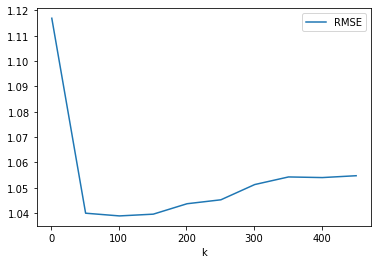

In [18]:
RMSEs = []
for k in range(1, 500, 50):
    RMSE = get_cf_RMSE(ratings_evaluation, ratings_train, cosine_similarity_matrix, average_rating, k)
    RMSEs.append({'k':k, 'RMSE':RMSE})

RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

It looks like the RMSE is the lowest somewhere between 50 and 150.  Due to the time needed to calculate I'm going to do a second sweep.  It might work out that 100 is the best k to use for this collaborative filter.

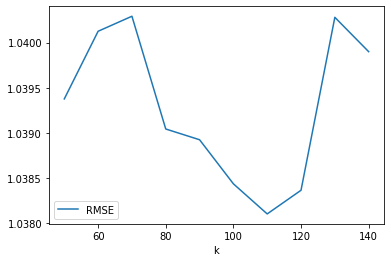

In [19]:
RMSEs = []
for k in range(50, 150, 10):
    RMSE = get_cf_RMSE(ratings_evaluation, ratings_train, cosine_similarity_matrix, average_rating, k)
    RMSEs.append({'k':k, 'RMSE':RMSE})

RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

It looks like the minimum is around 110.  Let's see if we can figure out the optimal k

In [20]:
min_RMSE = 100
optimal_k = 0

RMSEs = []

for k in range(100, 115, 1):
    RMSE = get_cf_RMSE(ratings_evaluation, ratings_train, cosine_similarity_matrix, average_rating, k)
    RMSEs.append({'k':k, 'RMSE':RMSE})
    if RMSE < min_RMSE:
        min_RMSE = RMSE
        optimal_k = k

print("A k of " + str(optimal_k) + " gives an RMSE of " + str(min_RMSE) + " on the evaluation set")

A k of 102 gives an RMSE of 1.0378712422979317 on the evaluation set


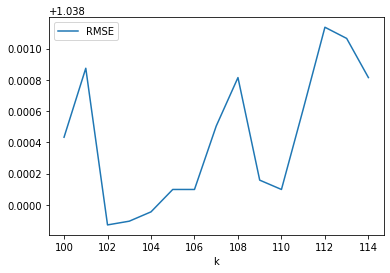

In [21]:
RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

So it looks like 102 is a fairly good choice for a k.  I will run with that.  Let's see how this "optimized" collaborative filter works on the test data set.

In [22]:
get_cf_RMSE(ratings_test, ratings_train, cosine_similarity_matrix, average_rating, optimal_k)

0.9755261627745621

Interesting.  The collaborative filter has an RMSE of 0.98.

## Summary

I implemented a SVD model on the MovieLens 100K dataset.  Two versions were tested and optimized.  One adjusted for the user bias, the other one didn't.  These two SVD models were pitted against an item based collaborative filter.  This collaborative filter was also optimized.  All three models were evaluated on a test data set.  The following table summarizes the RMSE of the predictions on the test set:

| Method                            | RMSE |
|-----------------------------------|------|
| SVD                               | 1.05 | 
| Bias Adjusted SVD                 | 1.05 |
| Item to Item Collaborative Filter | 0.98 |

The two SVD models generated very similar results.  The collaborative filter preformed much better.  I would hasten to note that these results may be due to my implementation of the SVD model.  For example, the [Surprise](http://surpriselib.com/) python package has an RMSE of 0.93 on their dataset.